In [11]:
"""
TIP: 
    1. Never use  [[0]*3]*3 for array assignment - This creates three duplicate list. Check out below code to view the weird result it gives:
        X = [[2]*3]*2
        X[0][0] = 3
        print(X)
        #Extremely weired!!! This is assigning to all the coloumn 0th element to 3.
"""
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from math import *

#TODO: Take input from the user
N = 2                 # Number of oscillators;
NEPOCHS = 1#10000        # Duration to run
DT = 0.01             # Time step between each epoch
    
#Constants
DEBUG = 1
MU = 1                   # Oscillator parameter (>0 for supercritical)
EPS = 0.9                # ε - coupling strength for error signal e(t) = D(t) - P(t)
ETA_W = 1000             #ηω - ωi' = -ηω*e(t)*sin(Фi) ; 1/η = 0.0001
ETA_ALPHA = 0.0001       #ηα - αi' = ηα*e(t)*ri*cos(Фi)
TAU = 0.0001             #τ - τ*Wij' = -Wij + zi(zj*)^(ωi/ωj)
ETA_OMEGA = 0.0001;      #these params are critical eta_omega = 0.0001

#Initialized at startup
R = np.zeros(N)          # R vector in polar coordinates for N oscillators
PHI = np.zeros(N)        # Ф vector for N oscillators
W = np.zeros(N)          # Natural frequencies of N oscillators
A = np.zeros([N, N])     # NxN connectivity matrix for N oscillators
THETA = np.zeros([N, N]) # NxN phase angle difference in complex coupling
ALPHA = np.zeros(N)      # NxN weight matrix for phase 1 teaching
IEXT = np.zeros([N, 3])  # For each oscillator external input freq, phase and amplitude

def initialize(N):
    """
    Parameters:
    R:     Initialize everything to 1
    PHI:   2*pi*rand(n, 1) - Uniformly distributed random number from 0 - 2ℼ 
    W:     { 0.01 + 45*2*pi*rand(n,1) - Given} For now assign in steps of 5
    A:     Randomly assign betwwn 0-1 uniformly distributed (TODO: constrain this later)
    THETA: Randomly assign between 0 - 2ℼ uniformly distributed
    APLHA: Initialize all to 0.09
    
    Constrain:
    θ12 = -θ21 = θ
    A12 = A21 = A
    MU = 1
    
    Return: 
    R, PHI, W, A, THETA
    """
    R = 2*np.ones(N) 
    PHI = 2*pi*np.random.rand(N)
    #PHI[0] = 3.7008 #Delete me
    #PHI[1] = 2.3106 #Delete me
    W = np.array([5 + i*5 for i in range(N)])
    print("W \n", W)
    print("PHI \n", PHI)
    
    #(i) Aij = Aji (ii) Aii = 0
    #Note: Make sure Aii is always zero to avoid numerical issues
    A = np.random.rand(N)
    A = np.dot(A[:,None], A[None,:])
    #A.fill(0.05) #Delete me
    np.fill_diagonal(A, 0)
    print("A \n", A)
    
    #θ12 = -θ21 = θ
    THETA = 2*pi*np.random.rand(N, N)
    THETA = (THETA - THETA.T)
    #THETA[0][1] = 1.8968 #Delete me
    #THETA[1][0] = -1.8968 #Delete me
    print("THETA \n", THETA)
    
    ALPHA = 0.09*np.ones(N)
    IEXT[:,0] = 1 #All external input componets have same amplitude
    IEXT[:,1] = np.array([10.0 + i*5 for i in range(N)]) #Also try setting frequency as that of oscillator itself
    IEXT[:,2] = 0 #Intially setting phase difference to zero. Later set it to some non zero values
    
    #Convert everythint o coloumn vector
    return R, PHI, W, A, THETA, ALPHA, IEXT
    

In [8]:
#TODO: write model here
def model(N, R, PHI, W, A, THETA, ALPHA, IEXT, NEPOCHS):
    """
    Parameters:
    NEPOCHS: How long to run the model
    
    TODO: Later add Iext as well
    
    Return:
    W: Change in W
    PHI: Change in pahse
    N_PHI_DIFF: Normalized pahse difference
    
    Miscellaneous:
        1. Normalized pahse difference approaches zero ss individual oscillators attain equillibrium 
    """
    # Be careful while changing these assignment!! Check out TIP section
    N_PHI_DIFF = np.zeros([N, N, NEPOCHS]) 
    PHI_ = np.zeros([N, NEPOCHS])
    R_ = np.zeros([N, NEPOCHS])
    W_ = np.zeros([N, NEPOCHS])
    
    ##S = np.zeros(NEPOCHS) #signal 
    ##ERR = np.zeros(NEPOCHS)
    #IEXT: contains n external signal of different amplitude, frequency and phase
    
    for t in range(NEPOCHS):
        # Why are they initializing R and THETA in every epoch?
        
        ##S[t] = np.sum(ALPHA*np.cos(PHI))
        ##ERR[t] = PTEACH[t] - S[t]
        
        """
            1. Vector form - do simultaneous update 
            2. Below system handles complex sinusiodal input
            3. In all matrix rows contain source oscillator, and 
               columns represent coupling to corresponding target oscillator
               
            Caution:
            Use coloumn vector for each oscillator to avoid confusion
        """
        #print("Interaction matrix \n", A)
        #print("Frequency \n", W)
        #print("Phase phi\n", PHI)
        
        NORM_FREQ = np.multiply(W[:,None], 1/W[None,:]) #ith row contains Wi/Wj
        NORM_FREQ[np.isnan(NORM_FREQ)] = 0
        NORM_PHASE = (PHI/W)[None,:] - (PHI/W)[:,None] + THETA/(W[:,None]*W[None,:]) #θij
        """
            Causes of NaN
            1. Negative entries in R matrix. Any negative entry in R results in NaN i.e. complex value
        """
        R_POW_NF = np.power(R, NORM_FREQ)
        
#         print("Norm freq\n", NORM_FREQ, "\n")
#         print("Norm phase\n", NORM_PHASE, "\n")
#         print("Rj\n", R_POW_NF, "\n")
#         print("PHI/W \n", (PHI/W)[:,None], "\n")
#         print("PHI/W \n", (PHI/W)[None,:], "\n")
#         print("THETA/{W[:,None]*W[None,:]} \n", THETA/(W[:,None]*W[None,:]), "\n")
        
        R_COUPLED = A*R_POW_NF*np.cos(W[:,None]*NORM_PHASE)
        PHI_COUPLED = A*(R_POW_NF/R[:,None])*np.sin(W[:,None]*NORM_PHASE)
        R_COUPLED = np.sum(R_COUPLED, axis=1)
        PHI_COUPLED = np.sum(PHI_COUPLED, axis=1)
        
        if np.isnan(PHI_COUPLED).any() or np.isnan(PHI_COUPLED).any():
            print("Interaction matrix \n", A)
            print("Frequency \n", W)
            print("R \n", R)
            print("Phase phi\n", PHI)
            print("Norm freq\n", NORM_FREQ, "\n")
            print("Norm phase\n", NORM_PHASE, "\n")
            print("R pow NF\n", R_POW_NF, "\n")
            print("R sum \n", R_COUPLED)
            print("Phi sum \n", PHI_COUPLED)
            break
        
        dR = ( (MU - R**2)*R + R_COUPLED + EPS*IEXT[:,0]*np.cos( IEXT[:,1]*DT*t + IEXT[:,2] - PHI) )*DT
        dPHI = ( W + PHI_COUPLED + EPS*(IEXT[:,0]/R)*np.sin( IEXT[:,1]*DT*t + IEXT[:,2] - PHI) )*DT
        dW = -EPS*IEXT[:,0]*np.sin( PHI - IEXT[:,1]*DT*t - IEXT[:,2])*DT
       
        #dR[np.isnan(dR)] = 0
        #dPHI[np.isnan(dPHI)] = 0
        #dW[np.isnan(dW)] = 0
            
        R = R + dR
        PHI = PHI + dPHI
        W = W + dW
        
        """
            Corrections:
            1. Non-negative oscillator frequencies
            2. Entries in R mtrix should not be negative
        """
        W[W < 0.01] = 0.01 #Restrict frequencies of oscillator to positive range only
        R[R < 0.01] = 0.01 #This avoids NaN restricting R to non-negative values
        
        R_[:,t] = R
        PHI_[:,t] = PHI
        W_[:,t] = W
        N_PHI_DIFF[:,:,t] = NORM_PHASE
                    
#             #Update rule for lateral weights considering amplitude remains constant 
# #             for j in range(N):
# #                 if i != j:
# #                     #A[i][j] = A[i][j] + 0*DT #No dynamics for Amplitude of lateral coupling
# #                     del_theta = W[j]*R[i]*(R[j]**(W[i]/W[j]))*sin( W[i]*( PHI[j]/W[j] - PHI[i]/W[i] + THETA[i][j]/(W[i]*W[j]) ) )/A[i][j] #Might give NaN
# #                     THETA[i][j] = THETA[i][j] + del_theta*DT/ETA_W
                    
#             #Dynamics for real forward weights
#             ##ALPHA[i] = ALPHA[i] + ( -ETA_W*ERR[t]*sin(PHI[i]) )*DT
            
    return R, PHI, R_, PHI_, W_, N_PHI_DIFF

W 
 [ 5 10]
PHI 
 [0.4243248  1.30552698]
A 
 [[0.         0.20220555]
 [0.20220555 0.        ]]
THETA 
 [[ 0.         -0.42393837]
 [ 0.42393837  0.        ]]


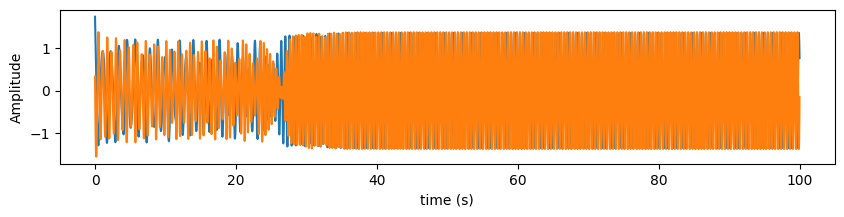

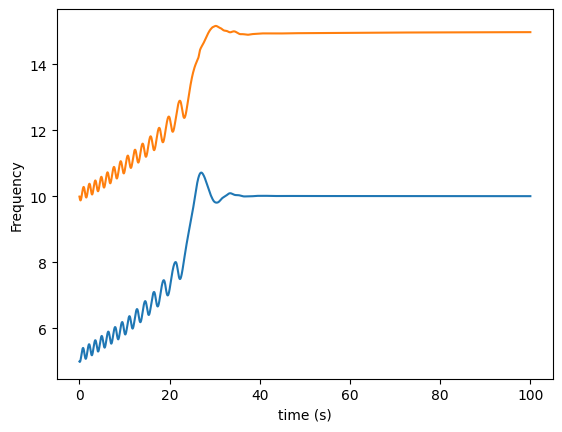

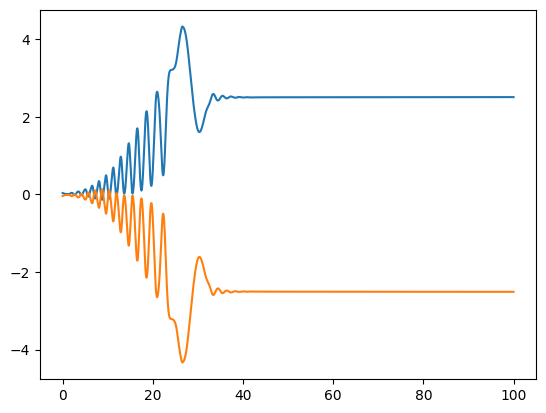

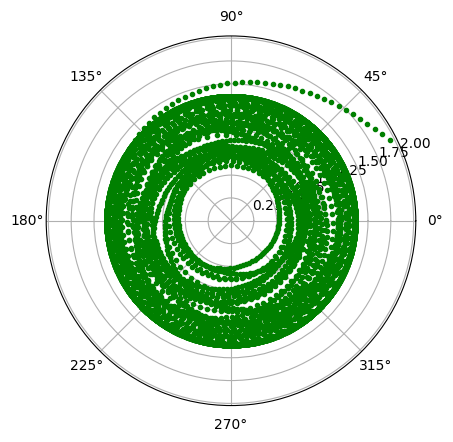

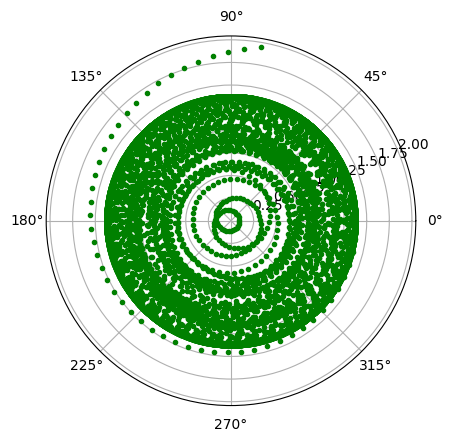

In [9]:
R, PHI, W, A, THETA, ALPHA, IEXT = initialize(N)
R, PHI, R_, PHI_, W_, N_PHI_DIFF = model(N, R, PHI, W, A, THETA, ALPHA, IEXT, NEPOCHS)

t = np.multiply([i for i in range(NEPOCHS)], DT)
X = [np.multiply(R_[i], np.cos(PHI_[i])) for i in range(N)] 

f = plt.figure()
f.set_figwidth(10)
f.set_figheight(2)
plt.xlabel("time (s)")
plt.ylabel("Amplitude")
for i in range(len(X)):
    plt.plot(t, X[i])
plt.show()

plt.xlabel("time (s)")
plt.ylabel("Frequency")
for i in range(len(X)):
    plt.plot(t, W_[i])
plt.show()

#plt.xlabel("time (s)")
#plt.ylabel("Normalized phase diff")
for i in range(N):
    for j in range(N):
        if i != j:
            plt.plot(t, N_PHI_DIFF[i][j])
plt.show()

plt.axes(projection = 'polar')
for i in range(N):
    plt.polar(PHI_[i], R_[i], 'g.')
    plt.show()


In [13]:
%debug

> /tmp/ipykernel_35303/2095839801.py(134)model()
    130 #             for j in range(N):
    131 #                 if j != i:
    132 #                     N_PHI_DIFF[i][j][t] = ( PHI[i]/W[i] - PHI[j]/W[j] - THETA[i][j]/(W[i]*W[j]) )
    133 
--> 134     return R, PHI, R_, PHI_, W_, N_PHI_DIFF



ipdb>  R_POW_NF 


array([[1., 1.],
       [1., 1.]])


ipdb>  NORM_FREQ


array([[0., 0.],
       [0., 0.]])


ipdb>  PHI


array([nan, nan])


ipdb>  THETA


array([[ 0.       , -2.6784066],
       [ 2.6784066,  0.       ]])


ipdb>  exit
